In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Sequential
import tensorflow as tf

2021-09-29 11:09:30.898534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64
2021-09-29 11:09:30.898553: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Deep Learning challenge

This challenge is split into 2 independent parts:
1. CNN challenge - Face to Age
2. RNN challenge - Sentiment Analysis of Movies Reviews

## 1. CNN challenge - Face to Age

### Objectives
-  Visualize images
-  Preprocess images for Neural Networks
-  Fit a custom CNN for a regression task
-  Fine-tune an analyse model performance

### 1.1 Visualize images

**👉 Load the dataset (200 Mo)**

In [62]:
df = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification/face_to_age/images.csv")
data = df.sample(frac=1, random_state=0).reset_index(drop=True)
data

,age,pixels
0,45,200 168 96 107 123 132 132 135 135 134 134 137...
1,1,223 226 231 234 236 238 238 240 240 240 240 23...
2,35,23 29 24 29 47 71 110 141 166 169 169 174 179 ...
3,28,9 6 11 12 30 65 82 37 47 16 27 26 32 74 141 16...
4,24,67 66 63 59 61 62 60 66 83 103 139 173 192 194...
...,...,...
23700,35,48 47 52 66 78 89 96 104 117 127 139 142 149 1...
23701,55,101 107 110 114 118 120 127 129 132 137 139 14...
23702,28,161 134 113 114 98 93 92 90 82 58 23 45 85 105...
23703,3,65 82 84 129 141 116 43 46 54 71 58 60 64 66 7...


Each row represent the image of a face in black and white
- `age` is the age in year
- `pixels` contains the 2304 (= 48 * 48) flatten values of each pixel in the image, in a black scale from 0 to 255, stored as string

**❓ Plot the histogram of age in your dataset.**

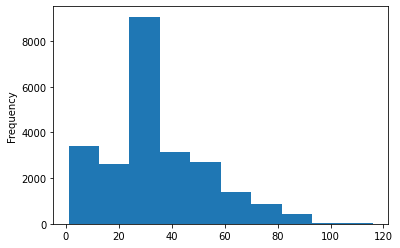

In [63]:
data.age.plot(kind = 'hist');

**❓ Visually display one image of your choice.**

In [64]:
image_example = np.array(data.pixels[17].split(), dtype = 'int16').reshape(48,48)

In [65]:
image_example

array([[ 91,  88,  88, ...,  82,  88,  82],
       [ 94,  90,  89, ...,  70,  84,  70],
       [ 82,  83,  82, ...,  62,  81,  69],
       ...,
       [ 98,  90,  97, ..., 212, 208, 186],
       [107, 100, 101, ..., 212, 212, 190],
       [115, 111, 106, ..., 217, 212, 173]], dtype=int16)

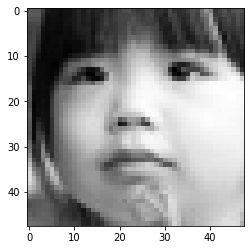

In [66]:
plt.imshow(image_example, cmap = 'gray')

**❓ What is the physical characteristic of the image at _index_ `60`?**

- Store in the 3 boolean variables `smile`/`glasses`/`hat` the values `True` if the person smiles/wears glasses/has a hat, `False` else.

In [67]:
image_60 = np.array(data.pixels[60].split(), dtype = 'int16').reshape(48,48)

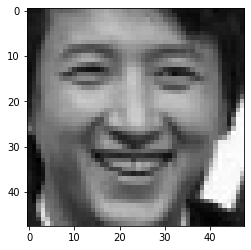

In [68]:
plt.imshow(image_60, cmap = 'gray')

In [69]:
data.iloc[60,:]

age                                                      27
pixels    24 26 25 36 63 93 98 96 100 101 106 114 122 13...
Name: 60, dtype: object

In [70]:
# Store your result in the variable below

smile = True
glasses = False
hat = False

#### 💾 Save your results

Run the cell below to save your results.

In [71]:
from nbresult import ChallengeResult
result = ChallengeResult('images_visualization',
                         smile=smile,
                         glasses=glasses,
                         hat=hat)
result.write()

### 1.2 Processing

**❓ Your goal is to train a convolutional neural network model to predict the _age_ of a person based solely on a picture of his/her face.**
- Create your **feature matrix** `X` as `ndarray` scaled between 0 and 1
- Create your **target vector** `y` as `ndarray`
- Create your holdout sets: 4 variables (`X_train`, `y_train`) and (`X_test`, `y_test`) keeping the **first** `70%` as the train set
- `X` and `y` shapes should fit a CNN (`model.fit(X,y)`)

😌 Don't worry, you will be given the solution in the next question in case you don't make it

In [72]:
convert_str_to_img(data.pixels[0]).shape

(48, 48)

In [102]:
def convert_str_to_img(x):
    x = x.split()
    x = [int(i)/255 for i in x]
    x = np.array(x).reshape(48,48)
    return x
X = np.array([convert_str_to_img(i) for i in data.pixels])
y = np.array(data.age)

In [98]:
# Check scaling
for i in X :
    if i.max() > 1 or i.min() < 0:
        print(error)

In [111]:
X = np.expand_dims(X,-1)

In [113]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

#### 💾 Save your results

Run the cell below to save your results.

In [114]:
from nbresult import ChallengeResult
result = ChallengeResult('images_processing', 
                         X_train_shape = X_train.shape,
                         y_train_shape = y_train.shape,
                         first_image = X_train[0]
                        )
result.write()

### 1.3 Modeling the age of a face

👉 **Only if you haven't managed to create your training sets above**, you can start back from the solution by running the cell below 
- ⚠️ This will download ~500Mo of `.pickle` files on your current working directory
- Then it will load them into 4 ndarrays in memory, and it should delete initial .pickles from your disk

In [29]:
import pickle

def download_solutions():
    file_names = ["images_X_train.pickle", "images_X_test.pickle", "images_y_train.pickle", "images_y_test.pickle"]
    base_url = "https://wagon-public-datasets.s3.amazonaws.com/certification/face_to_age/"
    pickles = dict()

    for file_name in file_names:
        url = f"{base_url + file_name}"
        file_path = f"data/images/{file_name}"
        command = f"curl --output {file_path} {url}"
        ! eval {command}
        with open(file_path, 'rb') as handle:
            pickles[file_name] = pickle.load(handle)
        command = f"rm {file_path}"
        ! eval {command}
        
    return pickles

# UNCOMMENT THIS LINE BELOW TO GET THE CORRECTION IF NEEDED
X_train, X_test, y_train, y_test = download_solutions().values()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  291M  100  291M    0     0  3339k      0  0:01:29  0:01:29 --:--:-- 3969k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  124M  100  124M    0     0  2753k      0  0:00:46  0:00:46 --:--:-- 3249k0  3653k      0  0:00:35  0:00:11  0:00:24 3648k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  129k  100  129k    0     0   386k      0 --:--:-- --:--:-- --:--:--  386k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 57039  100 57039    0     0   238k      0 --:--:-- --:--:-- --:--:--  237k


In [30]:
a,b,c,d = X_train, X_test, y_train, y_test

In [94]:
X_train.shape

(16593,)

❓ **Before training a complex model, evaluate your baseline score**
- We will use the mean absolute error in this challenge
- Compute the baseline score on your test set in the "naive" case where you always predict mean age
- Store the result under `score_baseline`

In [36]:
from sklearn.metrics import mean_absolute_error

score_baseline = mean_absolute_error(y_train, [y_train.mean() for i in range(len(y_train))])
score_baseline

15.289122175674974

❓ **Build and fit a convolutional neural network**

- Name it `model`
- Store output of `.fit()` in a variable `history`
- Do not use transfer learning
- Make sure your model does not overfit with appropriate control techniques

💡 Manage wisely your training time. You should obtain significantly better performance than the baseline in less than 5 minutes with average processor and no graphic cards. 

In [25]:
model = Sequential()
model.add(layers.Conv2D(16, (3,3), input_shape=(48, 48, 1), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, (2,2), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) 
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu')) # intermediate layer
model.add(layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                230450    
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [51]:
model2 = Sequential()
model2.add(layers.Conv2D(16, (3,3), input_shape=(48, 48, 1), activation="relu"))
model2.add(layers.Flatten())
model2.add(layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 16)        160       
_________________________________________________________________
flatten_2 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33857     
Total params: 34,017
Trainable params: 34,017
Non-trainable params: 0
_________________________________________________________________


In [44]:
from tensorflow.keras.callbacks import EarlyStopping

model2.compile(loss='mae',
              optimizer='adam', metrics='mae')
es = EarlyStopping(patience=4, restore_best_weights=True)
history2 = model2.fit(X_train, y_train, 
                    validation_split=0.3,
                    epochs=100,
                    callbacks=[es],
                    batch_size=32)

Epoch 1/100
363/363 [==============================] - 4s 9ms/step - loss: 14.8003 - mae: 14.8003 - val_loss: 13.0399 - val_mae: 13.0399
Epoch 2/100
363/363 [==============================] - 3s 9ms/step - loss: 12.7899 - mae: 12.7899 - val_loss: 12.2823 - val_mae: 12.2823
Epoch 3/100
363/363 [==============================] - 3s 9ms/step - loss: 12.0740 - mae: 12.0740 - val_loss: 11.8111 - val_mae: 11.8111
Epoch 4/100
363/363 [==============================] - 3s 9ms/step - loss: 11.6506 - mae: 11.6506 - val_loss: 11.5557 - val_mae: 11.5557
Epoch 5/100
363/363 [==============================] - 3s 9ms/step - loss: 11.2822 - mae: 11.2822 - val_loss: 11.3862 - val_mae: 11.3862
Epoch 6/100
363/363 [==============================] - 3s 9ms/step - loss: 11.0385 - mae: 11.0385 - val_loss: 11.2416 - val_mae: 11.2416
Epoch 7/100
363/363 [==============================] - 3s 8ms/step - loss: 10.8965 - mae: 10.8965 - val_loss: 10.9813 - val_mae: 10.9813
Epoch 8/100
363/363 [====================

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='mae',
              optimizer='adam', metrics='mae')
es = EarlyStopping(patience=4, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    validation_split=0.3,
                    epochs=100,
                    callbacks=[es],
                    batch_size=32)

Epoch 1/100
363/363 [==============================] - 7s 19ms/step - loss: 32.9475 - mae: 32.9475 - val_loss: 33.1390 - val_mae: 33.1390
Epoch 2/100
363/363 [==============================] - 7s 19ms/step - loss: 32.9475 - mae: 32.9475 - val_loss: 33.1390 - val_mae: 33.1390
Epoch 3/100
363/363 [==============================] - 7s 19ms/step - loss: 32.9475 - mae: 32.9475 - val_loss: 33.1390 - val_mae: 33.1390
Epoch 4/100
363/363 [==============================] - 6s 18ms/step - loss: 32.9475 - mae: 32.9475 - val_loss: 33.1390 - val_mae: 33.1390
Epoch 5/100
363/363 [==============================] - 6s 17ms/step - loss: 32.9475 - mae: 32.9475 - val_loss: 33.1390 - val_mae: 33.1390


❓ **Plot your training and validation MAE at each epoch using the cell below**

In [32]:
history.history

{'loss': [32.947513580322266,
  32.947509765625,
  32.94751739501953,
  32.947509765625,
  32.947513580322266],
 'mae': [32.947513580322266,
  32.947509765625,
  32.94751739501953,
  32.947509765625,
  32.947513580322266],
 'val_loss': [33.138954162597656,
  33.138954162597656,
  33.138954162597656,
  33.138954162597656,
  33.138954162597656],
 'val_mae': [33.138954162597656,
  33.138954162597656,
  33.138954162597656,
  33.138954162597656,
  33.138954162597656]}

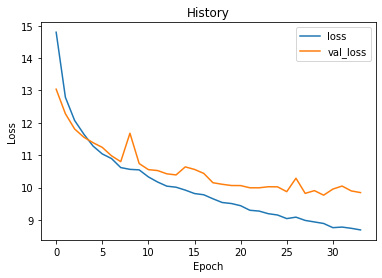

In [45]:
# Plot below your train/val loss history
plt.plot(history2.history['loss'], label = 'loss')
plt.plot(history2.history['val_loss'], label = 'val_loss')
plt.title('History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
fig.savefig("tests/history.png")

In [46]:
history = history2
model = model2

❓ **Evaluate your performances on test set**
- Store your test score as `score_test`

In [47]:
score_test = model.evaluate(X_test, y_test)[1]
score_test

223/223 [==============================] - 1s 3ms/step - loss: 9.7487 - mae: 9.7487


9.748650550842285

#### 💾 Save your results

Run the cell below to save your results.

In [50]:
from nbresult import ChallengeResult
import tensorflow as tf

result = ChallengeResult(
    "cnn",
    input_shape = list(model.input.shape),
    output_shape = list(model.output.shape),
    layer_names = [layer.name for layer in model.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in model.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()

## 2. RNN challenge - Binary Sentiment Analysis of French Movie Reviews

### 2.1 Data Preparation (given)

Our dataset contains 30,000 french reviews of movies, along with the binary class 1 (positive) or 0 (negative) score

In [4]:
# We load the dataset for you
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/certification/movies_reviews/movies_reviews.csv')
data.head()

,review,polarity
0,Ça commence à devenir énervant d'avoir l'impre...,0
1,"J'ai aimé ce film, si il ressemble a un docume...",1
2,Une grosse merde ce haneke ce faire produire p...,0
3,"Beau mélodrame magnifiquement photographié, ""V...",1
4,A la poursuite du diamant vers est un film pro...,1


In [5]:
# We create features
y = data.polarity
X = data.review

# We analyse class balance
print(pd.value_counts(y))

1    15051
0    14900
Name: polarity, dtype: int64


In [6]:
# We check the first review
print(f'polarity: {y[0]} \n')
print(X[0])

polarity: 0 

Ça commence à devenir énervant d'avoir l'impression de voir et revoir le même genre de film à savoir : la comédie romantique, surement le genre le plus prolifique de le production française actuelle. Le problème c'est que l'on a souvent affaire à des niaiseries de faible niveau comme celui ci. Avec un scenario ultra balisé et conventionnel, c'est à se demander comment ça peut passer les portes d'un producteur. Bref cette sempiternel histoire d'un homme mentant au nom de l'amour pour reconquérir une femme et qui à la fin se prend son mensonge en pleine figure est d'une originalité affligeante, et ce n'est pas la présence au casting de l'ex miss météo Charlotte Le Bon qui rêve surement d'avoir la même carrière que Louise Bourgoin qui change la donne.


#### Text Cleaning

We performed the following data cleaning for you:
- We replaced french accents by their non-accentuated equivalent
- We reduced all uppercases to lowercases
- We removed any characters outside of a-z

Below you can visualize the cleaned dataset:

In [7]:
X_clean = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification/movies_reviews/movies_reviews_clean.csv")['review']
X_clean[0]

'ca commence a devenir enervant de voir et revoir le meme genre de film a savoir la comedie romantique surement le genre le plus prolifique de le production francaise actuelle le probleme que a souvent affaire a des niaiseries de faible niveau comme celui ci avec un scenario ultra balise et conventionnel a se demander comment ca peut passer les portes producteur bref cette sempiternel histoire homme mentant au nom de pour reconquerir une femme et qui a la fin se prend son mensonge en pleine figure est originalite affligeante et ce pas la presence au casting de miss meteo charlotte le bon qui reve surement la meme carriere que louise bourgoin qui change la donne'

#### Text preprocessing

Then we performed the following preprocessing for you:
- We converted each review into a list of integers, each integer representing a _unique_ word from the corpus

- We padded every sequences with a maximum length of 100, replacing missing words by `0` at the end

- For example, the sentence: `"this was good"` is converted into something like `array([1, 3, 18, 0, 0, 0, ...0], dtype=int32)` 

Below you can visualize the preprocessed dataset:

In [8]:
!curl 'https://wagon-public-datasets.s3.amazonaws.com/certification/movies_reviews/movies_reviews_preproc.csv' --output "data/movies_reviews_preproc.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 71.4M  100 71.4M    0     0  1913k      0  0:00:38  0:00:38 --:--:-- 1938k0     0  1859k      0  0:00:39  0:00:13  0:00:26 1296k


In [9]:
X_preproc = np.genfromtxt("data/movies_reviews_preproc.csv", delimiter=',', dtype='int32')
print(X_preproc.shape)
X_preproc[0]

(29951, 100)


array([15, 16, 17, 18, 10, 12, 10, 19, 20,  6, 10, 21, 22, 23, 10, 24, 25,
        3, 26, 27,  3, 28, 29,  6, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        8, 40,  3, 41, 42, 43,  1, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56,  6, 57, 58, 59, 60,  8, 61,  3, 15, 62, 41, 63, 64, 65,
       66, 67, 68, 69, 70, 71,  8, 72, 73, 15, 74, 55, 75,  6, 76, 77, 78,
       10, 79, 61, 80, 18, 15, 11, 81, 25, 82, 83, 61, 84, 15, 85],
      dtype=int32)

Here is the dictionary used to translate words into integers:

In [10]:
!curl "https://wagon-public-datasets.s3.amazonaws.com/certification/movies_reviews/movies_reviews_word_to_integer.pickle" --output "data/word_to_integer.pickle"
import pickle

with open('data/word_to_integer.pickle', 'rb') as handle:
    word_to_id = pickle.load(handle)

word_to_id

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  848k  100  848k    0     0  1233k      0 --:--:-- --:--:-- --:--:-- 1233k


{'ca': 1,
 'commence': 2,
 'a': 3,
 'devenir': 4,
 'enervant': 5,
 'de': 6,
 'voir': 7,
 'et': 8,
 'revoir': 9,
 'le': 10,
 'meme': 11,
 'genre': 12,
 'film': 13,
 'savoir': 14,
 'la': 15,
 'comedie': 16,
 'romantique': 17,
 'surement': 18,
 'plus': 19,
 'prolifique': 20,
 'production': 21,
 'francaise': 22,
 'actuelle': 23,
 'probleme': 24,
 'que': 25,
 'souvent': 26,
 'affaire': 27,
 'des': 28,
 'niaiseries': 29,
 'faible': 30,
 'niveau': 31,
 'comme': 32,
 'celui': 33,
 'ci': 34,
 'avec': 35,
 'un': 36,
 'scenario': 37,
 'ultra': 38,
 'balise': 39,
 'conventionnel': 40,
 'se': 41,
 'demander': 42,
 'comment': 43,
 'peut': 44,
 'passer': 45,
 'les': 46,
 'portes': 47,
 'producteur': 48,
 'bref': 49,
 'cette': 50,
 'sempiternel': 51,
 'histoire': 52,
 'homme': 53,
 'mentant': 54,
 'au': 55,
 'nom': 56,
 'pour': 57,
 'reconquerir': 58,
 'une': 59,
 'femme': 60,
 'qui': 61,
 'fin': 62,
 'prend': 63,
 'son': 64,
 'mensonge': 65,
 'en': 66,
 'pleine': 67,
 'figure': 68,
 'est': 69,
 'orig

Finally, we holdout for you a test set

In [11]:
idx_split = round(len(X_preproc)*0.7)

X_train = X_preproc[0:idx_split]
y_train = y[0:idx_split]
X_test = X_preproc[idx_split:]
y_test = y[idx_split:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20966, 100) (20966,) (8985, 100) (8985,)


### 2.2 Modeling Sentiment Score

❓ **Before training a complex model, evaluate your baseline score**
- We will use the _accuracy_ as performance metric in this challenge
- What would be your baseline score?
- Store the result under `score_baseline`

In [12]:
score_baseline = 15051/(15051+14900)
score_baseline

0.5025207839471136

❓ **Build and fit a neural network**

- Name it `model`
- Store output of `.fit()` in a variable `history`
- You **cannot** use transfer learning nor any other pre-trained models
- You must use a **Recurrent** architecture to _capture_ a notion of order in the sentences' words
- Make sure your model does not overfit with appropriate control techniques
- You don't need to cross-validate your model. Simply hold-out a validation set as you see fit
- Manage wisely your training time

💡 You will not be judged by the computing power of your computer, but you should obtain significantly better performance than the baseline in less than 5 minutes without GPUs

In [13]:
len(word_to_id)

62379

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=4, restore_best_weights=True)

model = Sequential()
model.add(layers.Embedding(input_dim=len(word_to_id)+1,
                        output_dim=100,
                        mask_zero=True)) # Included masking layer :))
model.add(layers.LSTM(20))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
history = model.fit(X_train,y_train, epochs=10, validation_split=0.3, callbacks=es)


2021-09-29 11:10:31.726381: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-29 11:10:31.775367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-29 11:10:31.775758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 104.43GiB/s
2021-09-29 11:10:31.775915: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64
2021-09-29 11:10:31.776037: W tensorflow/stream_executor/platform/default/ds

Epoch 1/10
459/459 [==============================] - 22s 41ms/step - loss: 0.3980 - accuracy: 0.8270 - val_loss: 0.2653 - val_accuracy: 0.8935
Epoch 2/10
459/459 [==============================] - 18s 39ms/step - loss: 0.2006 - accuracy: 0.9223 - val_loss: 0.2635 - val_accuracy: 0.8983
Epoch 3/10
459/459 [==============================] - 18s 39ms/step - loss: 0.1480 - accuracy: 0.9465 - val_loss: 0.2629 - val_accuracy: 0.8983
Epoch 4/10
459/459 [==============================] - 17s 37ms/step - loss: 0.1190 - accuracy: 0.9564 - val_loss: 0.2633 - val_accuracy: 0.8965
Epoch 5/10
459/459 [==============================] - 18s 38ms/step - loss: 0.1012 - accuracy: 0.9635 - val_loss: 0.2910 - val_accuracy: 0.8921
Epoch 6/10
459/459 [==============================] - 17s 38ms/step - loss: 0.0844 - accuracy: 0.9696 - val_loss: 0.3539 - val_accuracy: 0.8806
Epoch 7/10
459/459 [==============================] - 18s 38ms/step - loss: 0.0749 - accuracy: 0.9735 - val_loss: 0.3228 - val_accuracy:

❓ **Plot your training and validation Accuracy at each epoch using the cell below**

In [15]:
history.history

{'loss': [0.3979785740375519,
  0.2005559653043747,
  0.1479722410440445,
  0.11897800862789154,
  0.10123715549707413,
  0.0844365581870079,
  0.07493593543767929],
 'accuracy': [0.8269964456558228,
  0.922322154045105,
  0.9465113282203674,
  0.9563913941383362,
  0.9634777903556824,
  0.9696102738380432,
  0.9734941124916077],
 'val_loss': [0.2653166353702545,
  0.2635073661804199,
  0.2628730535507202,
  0.26333221793174744,
  0.2909974157810211,
  0.3539017140865326,
  0.32281824946403503],
 'val_accuracy': [0.8934817314147949,
  0.8982511758804321,
  0.8982511758804321,
  0.8965023756027222,
  0.8920508623123169,
  0.8806041479110718,
  0.886804461479187]}

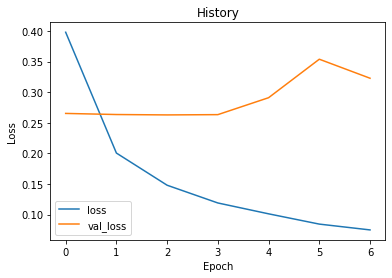

In [16]:
# Plot below your train/val loss history
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
fig.savefig("tests/history_rnn.png")

❓ **Evaluate your performances on test set**
- Store your test score as `score_test`

In [17]:
score_test = model.evaluate(X_test, y_test)[1]

281/281 [==============================] - 2s 6ms/step - loss: 0.2578 - accuracy: 0.8971


#### 💾 Save your results

Run the cell below to save your results.

In [19]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "rnn",
    input_shape = list(model.input.shape),
    output_shape = list(model.output.shape),
    layer_names = [layer.name for layer in model.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in model.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()